In [1]:
from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch
from prep_gan import find_nearest_index, to_utc

from distributed import Client
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator

import matplotlib.pyplot as plt
from models.generator import Generator
from models.critic import Critic

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

In [2]:
# stri = ""
# for var in list(xr.open_dataset(constants).data_vars)[:-1]:
#     stri+=var+","
# stri

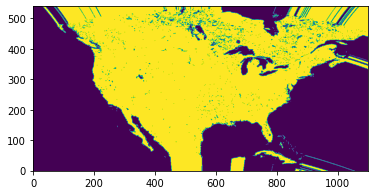

In [3]:
constants = "data/regrid_16_mask_wrfout_conus_constants_era_to_regrid.nc"
fine_mask = xr.open_dataset(constants)
plt.imshow(xr.open_dataset(constants).LANDMASK.values[0, ...], origin="lower")

In [4]:
fine_mask

<xarray.Dataset>
Dimensions:   (lat: 540, lon: 1100, time: 1)
Coordinates:
  * time      (time) float64 0.0
  * lon       (lon) float32 -139.1 -139.0 -138.9 -138.8 ... -56.78 -56.71 -56.63
  * lat       (lat) float32 18.14 18.21 18.29 18.36 ... 58.34 58.41 58.49 58.56
Data variables:
    LANDMASK  (time, lat, lon) float32 ...
Attributes: (12/111)
    CDI:                             Climate Data Interface version ?? (http:...
    Conventions:                     CF-1.6
    history:                         Thu May 27 13:11:42 2021: cdo remapnn,ta...
    TITLE:                            OUTPUT FROM WRF V3.4.1 MODEL
    START_DATE:                      2001-02-28_00:00:00
    SIMULATION_START_DATE:           2000-10-01_00:00:00
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    NCO:                             4.7.2
    CDO:                             Climate Data Operators version 1.9.3 (ht...

In [5]:
coarse_constants = "data/_grib2netcdf-webmars-public-svc-blue-005-6fe5cac1a363ec1525f54343b6cc9fd8-J3TMVF.nc"
coarse_mask = xr.open_dataset(coarse_constants)
coarse_mask = coarse_mask.sortby('latitude', ascending=True)
mlat1 = np.argmin(np.abs(fine_mask.lat.min()-coarse_mask.latitude).values)
mlat2 = np.argmin(np.abs(fine_mask.lat.max()-coarse_mask.latitude).values)
mlon1 = np.argmin(np.abs(fine_mask.lon.min()-(-360+coarse_mask.longitude)).values)
mlon2 = np.argmin(np.abs(fine_mask.lon.max()-(-360+coarse_mask.longitude)).values)
coarse_mask = coarse_mask.lsm[0, mlat1:mlat2, mlon1:mlon2]

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [7]:
device

device(type='cuda', index=0)

In [8]:
# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client=Client(n_workers=8, threads_per_worker=2, memory_limit="1.5GB")
client

Client Scheduler: tcp://127.0.0.1:37177 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 11.18 GiB


Load data and extract synchronous time stamps

In [9]:
hr_dataroot_U10 = "data/wrf/U10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "data/wrf/V10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_V10*.nc"

fine_u = xr.open_mfdataset(glob.glob(hr_dataroot_U10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})
fine_v = xr.open_mfdataset(glob.glob(hr_dataroot_V10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})

In [10]:
dataroot = "./data/interim_2000-10-01_to_2013-09-30.nc"

target = '10UV_GDS4_SFC'
coarse = xr.open_dataset(dataroot).astype("float")
coarse = coarse.sortby('latitude', ascending=True)
coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

# scale factor
sf = 8

In [11]:
coarse_u10.time.min(), coarse_u10.time.max()

(<xarray.DataArray 'time' ()>
 array('2000-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()>
 array('2013-09-30T18:00:00.000000000', dtype='datetime64[ns]'))

Mark starting long and lat boundaries

In [12]:
coarse_u10.longitude.min(), coarse_u10.latitude.min()

(<xarray.DataArray 'longitude' ()>
 array(-139.055, dtype=float32),
 <xarray.DataArray 'latitude' ()>
 array(18.137, dtype=float32))

Fine the regular grid size

In [13]:
np.diff(coarse_u10.longitude).mean()/sf, np.diff(coarse_u10.latitude).mean()/sf

(0.09375114738941193, 0.09375)

Number of steps

In [14]:
coarse_u10.longitude.shape[0]*sf, coarse_u10.latitude.shape[0]*sf

(880, 432)

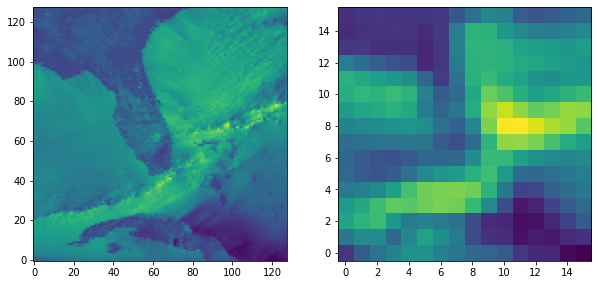

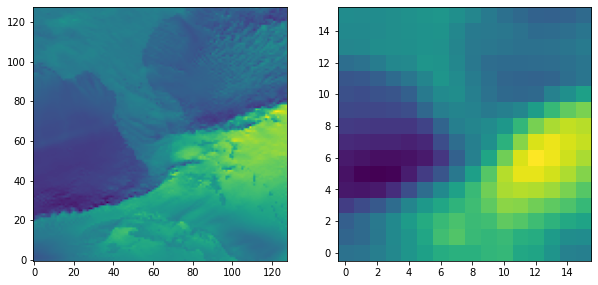

In [15]:
tidx = 15000
vmin, vmax = -13, 6
low, up, l, r = 4, 20, 70, 86
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(fine_u.U10[tidx, sf*low:sf*up, sf*l:sf*r], origin="lower",)# vmin=vmin, vmax=vmax)
ax[1].imshow(coarse_u10[tidx, low:up, l:r], origin="lower", )#vmin=vmin, vmax=vmax)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(fine_v.V10[tidx, sf*low:sf*up, sf*l:sf*r], origin="lower",)# vmin=vmin, vmax=vmax)
ax[1].imshow(coarse_v10[tidx, low:up, l:r], origin="lower", )#vmin=vmin, vmax=vmax)



In [22]:
import datetime as datetime
import pandas as pd
Times_dt = []
for t in fine_u.Times:
    year = int(str(float(t))[:4])
    month = int(str(float(t))[4:6])
    day = int(str(float(t))[6:8])
    hours = int(np.round(24*float(str(float(t))[8:])))
    Times_dt.append(np.datetime64(datetime.datetime(year, month, day, hours)))
Times_dt = np.array(Times_dt).astype('datetime64[D]')
Times_dt_pd = pd.DatetimeIndex(Times_dt)

In [23]:
coarse_u10.time.values.astype(np.datetime64), Times_dt

(array(['2000-10-01T00:00:00.000000000', '2000-10-01T06:00:00.000000000',
        '2000-10-01T12:00:00.000000000', ...,
        '2013-09-30T06:00:00.000000000', '2013-09-30T12:00:00.000000000',
        '2013-09-30T18:00:00.000000000'], dtype='datetime64[ns]'),
 array(['2000-10-01', '2000-10-01', '2000-10-01', ..., '2013-09-30',
        '2013-09-30', '2013-09-30'], dtype='datetime64[D]'))

In [34]:
Times_dt_pd.astype(object)[0].month

10

In [44]:
filter_func = np.vectorize(lambda x: True if x.month in [6, 7, 8, 9, 10] else False)
# season_filter = Times_dt_pd[filter_func(Times_dt_pd.astype(object))]
time_mask = filter_func(Times_dt_pd.astype(object))

In [45]:
np.sum(time_mask)

7956

In [46]:
season_filter

DatetimeIndex(['2001-06-01', '2001-06-01', '2001-06-01', '2001-06-01',
               '2001-06-02', '2001-06-02', '2001-06-02', '2001-06-02',
               '2001-06-03', '2001-06-03',
               ...
               '2013-08-29', '2013-08-29', '2013-08-30', '2013-08-30',
               '2013-08-30', '2013-08-30', '2013-08-31', '2013-08-31',
               '2013-08-31', '2013-08-31'],
              dtype='datetime64[ns]', length=4784, freq=None)

In [47]:
to_utc(coarse_u10.time.values.astype('datetime64[D]')), to_utc(Times_dt)

(array([9.7035840e+08, 9.7035840e+08, 9.7035840e+08, ..., 1.3804992e+09,
        1.3804992e+09, 1.3804992e+09]),
 array([9.7035840e+08, 9.7035840e+08, 9.7035840e+08, ..., 1.3804992e+09,
        1.3804992e+09, 1.3804992e+09]))

In [48]:
coarse_mask.values.shape

(54, 109)

In [20]:
u10 = fine_u.U10[time_mask, sf*low:sf*up, sf*l:sf*r]
v10 = fine_v.V10[time_mask, sf*low:sf*up, sf*l:sf*r]
fmask = np.repeat(fine_mask.LANDMASK.values[0, sf*low:sf*up, sf*l:sf*r][np.newaxis, :, :], u10.shape[0], axis=0)

coarse_u10_patch = coarse_u10[time_mask, low:up, l:r]
coarse_v10_patch = coarse_v10[1:18000, low:up, l:r]
cmask = np.repeat(coarse_mask.values[low:up, l:r][np.newaxis, :, :], u10.shape[0], axis=0)

u10 = xr_standardize_field(u10)
v10 = xr_standardize_field(v10)
coarse_u10_patch =  xr_standardize_field(coarse_u10_patch)
coarse_v10_patch =  xr_standardize_field(coarse_v10_patch)

print(u10.shape)

(17999, 128, 128)


In [21]:
# assert np.isclose(float(u10.mean().compute()), 0.0, atol=10-5)
# assert np.isclose(float(v10.mean().compute()), 0.0, atol=10-5)

# assert np.isclose(float(coarse_u10_patch.mean().compute()), 0.0, atol=10-5)
# assert np.isclose(float(coarse_v10_patch.mean().compute()), 0.0, atol=10-5)

# assert np.isclose(float(u10.std().compute()), 1.0, atol=10-5)
# assert np.isclose(float(v10.std().compute()), 1.0, atol=10-5)

# assert np.isclose(float(coarse_u10_patch.std().compute()), 1.0, atol=10-5)
# assert np.isclose(float(coarse_v10_patch.std().compute()), 1.0, atol=10-5)

In [22]:
coarse_mask.shape, coarse_u10_patch.shape

((54, 109), (17999, 16, 16))

In [23]:
coarse = np.stack([coarse_u10_patch, coarse_v10_patch, cmask], axis=1)
fine = np.stack([u10, v10, fmask], axis=1)

del coarse_u10_patch
del coarse_v10_patch
del cmask
del fmask
# coarse = xr.concat([coarse_u10_patch, coarse_v10_patch], dim="var").transpose('time', 'var', 'latitude', 'longitude')
# fine = xr.concat([u10, v10], dim="var").transpose('Times', 'var', 'lat', 'lon')

In [24]:
coarse.shape, fine.shape

((17999, 3, 16, 16), (17999, 3, 128, 128))

In [25]:
# PCA
# ncomp = 250
# fine_pca_u10 = np.array(fine[:, 0, ...]).reshape(u10.shape[0], u10.shape[1]*u10.shape[2])
# pca = PCA(n_components=ncomp)
# pca.fit(fine_pca_u10)
# fine_sp_basis_u10 = pca.components_.reshape(ncomp, u10.shape[1]*u10.shape[2])/pca.explained_variance_[:, np.newaxis]
# del fine_pca_u10
# # fine_sp_basis_u10 = np.divide(fine_sp_basis_u10, pca.explained_variance_)

# fine_pca_v10 = np.array(fine[:, 1, ...]).reshape(v10.shape[0], v10.shape[1]*v10.shape[2])
# pca = PCA(n_components=ncomp)
# pca.fit(fine_pca_v10)
# del fine_pca_v10

# fine_sp_basis_v10 = pca.components_.reshape(ncomp, v10.shape[1]*v10.shape[2])/pca.explained_variance_[:, np.newaxis]
# fine_sp_basis = np.stack([fine_sp_basis_u10, fine_sp_basis_v10], axis=1)
# del fine_sp_basis_v10
# del fine_sp_basis_u10

# print(fine_sp_basis.shape)

In [26]:
X = np.array(fine[:, 0, ...]).reshape(u10.shape[0], u10.shape[1]*u10.shape[2])
X.shape

(17999, 16384)

In [ ]:
cov_matrix = np.cov(X)

In [27]:
w, v = np.linalg.eig(X)

LinAlgError: Last 2 dimensions of the array must be square

In [27]:
max_comp = 50
# pca = PCA(n_components=max_comp)

from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(batch_size=200, n_components=16384)
pca.fit(X)

ValueError: n_components=16384 must be less or equal to the batch number of samples 200.

In [ ]:
X.shape, pca.components_.shape

In [ ]:
from sklearn.decomposition import IncrementalPCA
# pca = IncrementalPCA()
# pca.fit(X)

In [72]:
# N1, N2 = 0, 15
# Z = pca.components_[N1:N2].T*X
# Z.shape

AttributeError: 'IncrementalPCA' object has no attribute 'components_'

In [ ]:
cov_matrix = np.cov(X)

In [66]:
XX = np.sum(pca.components_[N1:N2]*Z[0, ...], axis=0)

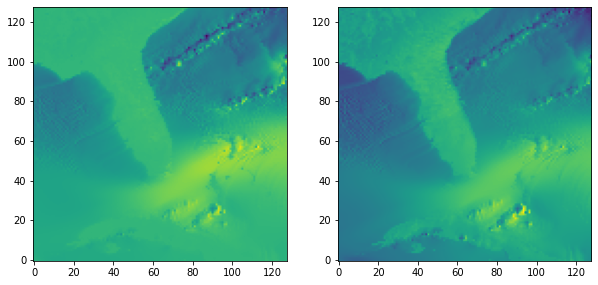

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
# n = 10
ax[0].imshow(XX.reshape(u10.shape[1], u10.shape[2]), origin="lower")
ax[1].imshow(X[0, ...].reshape(u10.shape[1], u10.shape[2]), origin="lower")

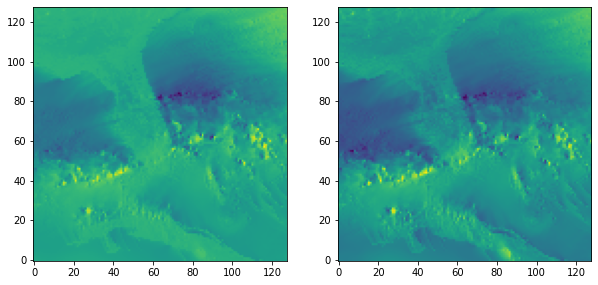

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
n = 10
ax[0].imshow((pca.components_*X[n, ...])[0, ...].reshape(u10.shape[1], u10.shape[2]), origin="lower")
ax[1].imshow(X[n, ...].reshape(u10.shape[1], u10.shape[2]), origin="lower")

In [ ]:
pca.components_.shape

In [68]:
# pca.components*ca.singular_values_[:max_comp].shape

(500,)

In [52]:
# Xlow = pca.singular_values_[:10]*np.dot(pca.components_, X).T

In [53]:
# np.sum(Xlow, axis=1).shape

In [88]:
128*128
Xdot = np.dot(pca.components_[:max_comp, ...], X.T)

In [89]:
Xdot.shape

(500, 17999)

In [71]:
max_comp = 500
X_low = pca.components_[:max_comp, ...].T*pca.singular_values_[:max_comp]
# X_low.shape
# plt.imshow(np.sum(X_low, axis=1).reshape(u10.shape[1], u10.shape[2]), origin="lower")
# plt.imshow(np.sum(X_low, axis=1).reshape(u10.shape[1], u10.shape[2]), origin="lower")
X_low.shape

(16384, 500)

In [27]:
fine_sp_basis[:, 0, ...].shape, v10.shape
fine_pca_v10 = np.array(fine[:, 1, ...]).reshape(v10.shape[0], v10.shape[1]*v10.shape[2])
fine_pca_v10.shape, fine_sp_basis[:, 0, ...].shape, v10.shape

((17999, 16384), (250, 16384), (17999, 128, 128))

In [28]:
tester = fine_pca_v10*fine_sp_basis[0, 0, ...]


In [30]:
tester.shape

(17999, 16384)

In [26]:
fine_t = torch.from_numpy(np.array(fine)).float()
coarse_t = torch.from_numpy(np.array(coarse)).float()
pcas_t = torch.from_numpy(fine_sp_basis).float()
pcas_t.size(), coarse_t.size(), pcas_t.dtype, coarse_t.dtype

(torch.Size([25, 2, 16384]),
 torch.Size([17999, 3, 16, 16]),
 torch.float32,
 torch.float32)

In [27]:
del u10
del v10

NameError: name 'coarse_u10_patch' is not defined

In [29]:
# del fine_pca_u10
# del fine_pca_v10
del fine_sp_basis

In [30]:
del coarse
del fine

In [31]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
batch_size = 64
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True
)

In [32]:
device

device(type='cuda', index=0)

In [33]:
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:2, ...], "fine": real_batch[:2, ...]}
pcas.size()
pcas.shape, fixed["coarse"].shape, fixed["fine"].shape,

(torch.Size([64, 1, 25, 2, 16384]),
 torch.Size([2, 3, 16, 16]),
 torch.Size([2, 3, 128, 128]))

In [34]:
# from models import Generator, Discriminator
# discriminator_test = Discriminator(15, 120, 2)
# generator_test = Generator(15, 120, 2)
# gt = generator_test(fixed["coarse"])
# print(gt.shape)

# discriminator_test(fixed["fine"]).shape,
# generator_test(fixed["coarse"]).shape,
# discriminator_test(gt)

In [35]:
device

device(type='cuda', index=0)

In [36]:
# from models import Generator, Discriminator#, patch_discriminator

# discriminator = patch_discriminator().to(device)#Discriminator(7, 14, 1).to(device)
critic = Critic(16, 128, 3).to(device)
generator = Generator(16, 128, 3).to(device)
lr = 0.00025

In [39]:
pcas_t.size()

torch.Size([25, 2, 16384])

In [ ]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
C_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
epochs = 500
models = {"generator": generator, "critic": critic, "gen_optimizer": G_optimizer, "critic_optimizer": C_optimizer}
hyper_params = {
    "gp_weight": 10,
    "critic_iterations": 5,
    "batch_size": batch_size,
    "gamma": 0.01,
    "eof_weight": (1-0.01)/4,
    "div_weight": (1-0.01)/4,
    "vort_weight": (1-0.01)/4,
    "content_weight": (1-0.01)/4,
}

run_params = {
    "epochs": epochs,
    "print_every": 500,
    "save_every": 250,
    "use_cuda": True,
    "device": device,
    "log_path": "mlruns"
}


# trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
#                   use_cuda=torch.cuda.is_available(), print_every=500, save_every=500, device=device)
experiment = "WGAN-GP Extended Loss Equal Weights"
tags = {"description": "equal weights on loss"}

from mlflow.tracking import MlflowClient
client = MlflowClient()
# print(dir(client))
print(client.get_experiment_by_name(experiment).experiment_id)


trainer = Trainer(models, hyper_params, run_params, experiment, tags)

# Train model for N epochs
trainer.train(
    dataloader,
    epochs=epochs,
    fixed=fixed,
)
torch.cuda.empty_cache() 

INFO:root:
Epoch 0


1


INFO:root:Gradient Penalty: 523.0858154296875
INFO:root:Wasserstein Distance Estimate: 1166.60986328125
INFO:root:System Free Memory: 480.0
INFO:root:Iteration number: 250
INFO:root:GPU Memory: 874834432
INFO:root:EOF Coefficient L2: 1.888074278831482
INFO:root:Divergence L2: 2.003021478652954
INFO:root:Vorticity L2: 2.000440835952759
INFO:root:Content L2: 0.6318665742874146
INFO:root:Generator loss: 1.2750272750854492
INFO:root:
Epoch 1
INFO:root:Gradient Penalty: 319.2750244140625
INFO:root:Wasserstein Distance Estimate: 799.5914916992188
INFO:root:System Free Memory: 404.0
INFO:root:Iteration number: 500
INFO:root:GPU Memory: 874834432
INFO:root:EOF Coefficient L2: 2.0836987495422363
INFO:root:Divergence L2: 2.0104095935821533
INFO:root:Vorticity L2: 2.0054028034210205
INFO:root:Content L2: 0.7093071937561035
INFO:root:Generator loss: -0.4814574718475342
INFO:root:
Epoch 2
INFO:root:Gradient Penalty: 350.627685546875
INFO:root:Wasserstein Distance Estimate: 831.928466796875
INFO:roo

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
import mlflow
mlflow.start_run?

In [28]:
import mlflow
logged_model = 'file:///home/nannau/msc/DoWnGAN/mlruns/1/804c42df4312453d8506e8b16fd46bc7/artifacts/Generator'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [29]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: Generator
  flavor: mlflow.pytorch
  run_id: 804c42df4312453d8506e8b16fd46bc7

In [32]:
loaded_model = mlflow.pytorch.load_model(logged_model).to(device)
loaded_model(fixed["coarse"].to(device))

tensor([[[[-3.5388e-01, -4.8582e-01, -5.9356e-01,  ..., -1.3861e+00,
           -1.1772e+00, -8.4754e-01],
          [-3.7704e-01, -4.5386e-01, -5.6603e-01,  ..., -1.4965e+00,
           -1.2917e+00, -1.0280e+00],
          [-4.3806e-01, -5.8303e-01, -6.0858e-01,  ..., -1.7329e+00,
           -1.4795e+00, -1.0681e+00],
          ...,
          [ 1.2753e-01,  1.1490e-01,  1.6337e-01,  ..., -2.9095e-02,
            7.5807e-03,  2.4980e-02],
          [ 9.2736e-02,  9.5301e-02,  1.3478e-01,  ..., -4.0386e-03,
            2.4528e-02,  4.6090e-02],
          [ 9.7056e-02,  9.9583e-02,  1.2274e-01,  ...,  5.7548e-02,
            3.5298e-02,  3.6050e-02]],

         [[ 3.6496e-01,  4.0098e-01,  4.1650e-01,  ...,  3.4476e-03,
            5.0537e-02, -1.2567e-01],
          [ 4.7568e-01,  5.3864e-01,  6.4374e-01,  ...,  1.2802e-02,
           -1.5882e-03, -7.8880e-03],
          [ 5.9953e-01,  7.1660e-01,  6.8409e-01,  ...,  8.9383e-02,
            1.1287e-01,  8.7134e-02],
          ...,
     

In [3]:
import mlflow
runs = mlflow.search_runs(experiment_ids="1")
runs.head(10)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Wasserstein Distance Estimate,metrics.Divergence L2,metrics.GPU Memory,metrics.EOF Coefficient L2,...,params.vort_weight,params.critic_iterations,tags.mlflow.source.name,tags.mlflow.source.git.commit,tags.mlflow.source.type,tags.mlflow.user,tags.6448b64a8d8a445288375be22ed1b270,tags.mlflow.log-model.history,tags.be35a158b37f4b18b52e7da67f3ab7cf,tags.804c42df4312453d8506e8b16fd46bc7
0,6448b64a8d8a445288375be22ed1b270,1,RUNNING,file:///home/nannau/msc/DoWnGAN/mlruns/1/6448b...,2021-05-26 21:22:45.426000+00:00,NaT,NaN,NaN,NaN,NaN,...,0.2475,5,process_data.py,82040d9938170a941bf93c4379283b664f18279e,LOCAL,nannau,{'description': 'equal weights on loss'},None,None,None
1,be35a158b37f4b18b52e7da67f3ab7cf,1,FAILED,file:///home/nannau/msc/DoWnGAN/mlruns/1/be35a...,2021-05-26 21:06:09.803000+00:00,2021-05-26 21:20:25.045000+00:00,168.159500,1.982799,261215744.0,2.036446,...,0.2475,5,process_data.py,82040d9938170a941bf93c4379283b664f18279e,LOCAL,nannau,None,"[{""run_id"": ""be35a158b37f4b18b52e7da67f3ab7cf""...",{'description': 'equal weights on loss'},None
2,804c42df4312453d8506e8b16fd46bc7,1,RUNNING,file:///home/nannau/msc/DoWnGAN/mlruns/1/804c4...,2021-05-26 19:25:09.495000+00:00,NaT,90.006012,1.965402,261215744.0,1.771552,...,0.2475,5,process_data.py,82040d9938170a941bf93c4379283b664f18279e,LOCAL,nannau,None,"[{""run_id"": ""804c42df4312453d8506e8b16fd46bc7""...",None,{'description': 'equal weights on loss'}
